# Sustainable energy companies and its comparison to standard ones

##  Data analysis and visualisation part
In this notebook, we will observe how many of the sustainable and how many of the unsustainable stocks would our porfolio selection methods use

In [27]:
# Importing packages
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import datetime as dt
import yfinance as yf
import seaborn as sns
import functools as reduce
from scipy import optimize

## Portfolio Selection Functions

### Auxiliary Functions

In [28]:
# Portfolio standard deviation
def standard_deviation(weights: np.array, cov_matrix: np.array) -> float:
    """Calculates the standard deviation of the portfolio"""
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Expected return
def neg_expected_return(weights: np.array, log_returns: np.array) -> float:
    """Calculates the annulazied Expected return of the portfolio
    as a simple mean of the returns on specified assets"""
    return -np.sum(log_returns.mean()*weights)*252

# Sharpe Ratio
def neg_sharpe_ratio(weights: np.array, log_returns: np.array, cov_matrix: np.array, risk_free_rate: float) -> float:
    """Calculates the negative sharpe ratio of the portfolio"""
    return (neg_expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

### Optimization of Weights

In [29]:
def optimize_portfolio(adj_close_data: pd.DataFrame , min_weight: float,
                       max_weight: float, method: str, rf_rate: float = 0.02):
    """Takes in data on adjusted close prices of specified assets, minimum and maximum
    proportion of one asset in the portfolio, preferred portfolio selection method, either min_variance,
    max_exp_return or max_sharpe, and returns an object containing optimized weights of the portfolio."""
    
    # Log returns extraction
    log_returns = np.log(adj_close_data / adj_close_data.shift(1)).dropna()
    
    # Annualized covariance matrix
    cov_matrix = log_returns.cov() * 252
    
    # calculate variables for optimization
    init_weights = np.array([1/log_returns.shape[1]]*log_returns.shape[1])
    df_std_dev = standard_deviation(init_weights, cov_matrix)
    df_exp_return = -neg_expected_return(init_weights, log_returns = log_returns)
    df_sharpe = neg_sharpe_ratio(init_weights, log_returns, cov_matrix, rf_rate)
    
    # Set optimization constraints
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = [(min_weight, max_weight) for _ in range(log_returns.shape[1])]
    
    if method == "max_sharpe":
    # minimize negative sharpe ratio
        optimized_results = optimize.minimize(neg_sharpe_ratio, init_weights,
                    args=(log_returns, cov_matrix, rf_rate), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "min_variance":
        optimized_results = optimize.minimize(
        standard_deviation, init_weights,
        args=(cov_matrix), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "max_exp_return":
        optimized_results = optimize.minimize(neg_expected_return, init_weights,
        args=(log_returns), method='SLSQP', constraints=constraints, bounds=bounds)

    return optimized_results

## Functions for performing exploratory analysis

In [30]:
def analyze_dataset(df, summary_stat=False, data_quality=False, exploratory_analysis=False):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The provided input is not appropriate DataFrame.")

    # Summary Statistics
    if summary_stat: 
        print("Shape of the DataFrame:", df.shape)
        print("First 5 rows of the DataFrame:")
        print(df.head(5))
        print("DataFrame Info:")
        print(df.info())
        print("Descriptive Statistics:")
        print(df.describe())

    # Data Quality Check
    if data_quality:
        print("Number of missing values in each column:")
        print(df.isna().sum())
        print("Duplicate rows in the DataFrame:")
        print(df[df.duplicated()])

    # Exploratory Analysis
    if exploratory_analysis:
        # Graph of Stocks
        plt.figure(figsize=(15, 6))
        for column in df.columns:
            plt.plot(df.index, df[column], label=column)
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.title('Selected Asset Values Over Time')
        plt.legend()
        plt.show()

        # Each Stock Alone
        ncols = 4
        nrows = int(np.ceil(len(df.columns) / ncols))
    
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
        axes = axes.flatten()
        for i, column in enumerate(df.columns):
            axes[i].plot(df.index, df[column])
            axes[i].set_title(column, fontsize=10)
            axes[i].set_xlabel('Date', fontsize=8)
            axes[i].set_ylabel('Value', fontsize=8)
            axes[i].tick_params(axis='x', labelrotation=45)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.tight_layout(pad=3.0)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.show()

        # Box Plot Distribution Analysis
        print("Box plot for distribution analysis")
        ax = df.plot(kind='box')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.tick_params(axis='x', labelsize=8)
        plt.show()

        # Heatmap for Correlation Between Assets
        print("Heatmap for Correlation Between Assets")
        correlation_matrix = df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True)
        plt.tight_layout()
        plt.show()


## Loading the Data 
- We will take some of the biggest renewable Energy Companies in the World and create on portfolio from them
- And we will also take some of the largest energy companies that do not focus maily on sustainable resouces

### Processing user input

Sustainable stocks: AQN,BEPC,CEG,CSIQ,DQ,GE,IBDRY,JKS,NEE,VWDRY

Unsustainable stocks: EQNR,BP,0857.HK,COP,FP.VI,SHEL,CVX,SR,ENEL.MI

In [31]:
# Specify the tickers :
user_input_str = input("Enter a list of tickers you want to analyze, separated by a comma only: ")

user_input_list = user_input_str.split(',')

# Remove leading and trailing whitespaces from each string in the list
tickers = [item.strip() for item in user_input_list]

# create the adjusted close price dataframe
adj_close_df = pd.DataFrame()

# populate the dataframe with adjusted close price data of specified assets
for ticker in tickers:
    data = yf.download(ticker, period = "2y", interval = "1d")
    adj_close_df[ticker] = data["Adj Close"]

Enter a list of tickers you want to analyze, separated by a comma only:  AQN,BEPC,CEG,CSIQ,DQ,GE,IBDRY,JKS,NEE,VWDRY, EQNR,BP,0857.HK,COP,FP.VI,SHEL,CVX,SR,ENEL.MI


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of the DataFrame: (503, 19)
First 5 rows of the DataFrame:
                  AQN       BEPC        CEG       CSIQ         DQ         GE  \
Date                                                                           
2022-02-07  12.433211  31.144829  45.105209  26.709999  37.169998  77.417946   
2022-02-08  12.442009  31.439520  44.547150  27.340000  38.919998  76.960724   
2022-02-09  12.591595  32.636688  46.319248  28.200001  42.400002  76.914238   
2022-02-10  12.389215  32.120991  46.064690  27.910000  40.580002  76.557762   
2022-02-11  12.301224  31.890764  47.082909  27.600000  38.790001  75.038841   

                IBDRY        JKS        NEE     VWDRY       EQNR         BP  \
Date                                                                          
2022-02-07  39.764935  38.463249  72.064590  8.434753  25.237240  30.517359   
2022-02-08  39.472336  40.099373  71.855087  8.255078  24.618183  30.032230   
2022-02-09  39.865501  41.496296  72.997780  8.644374  25.

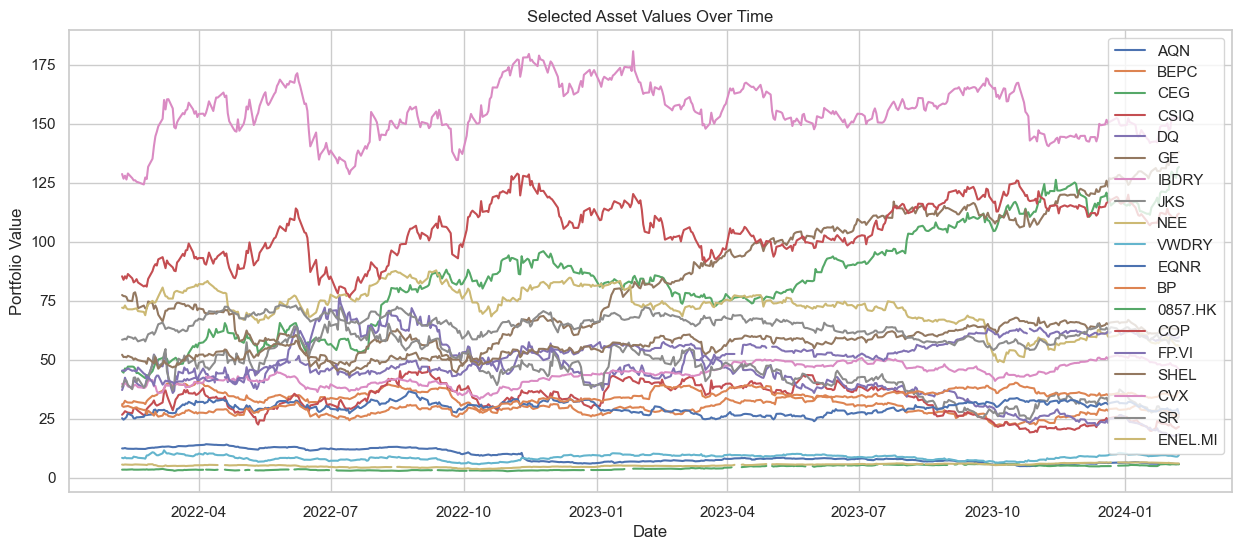

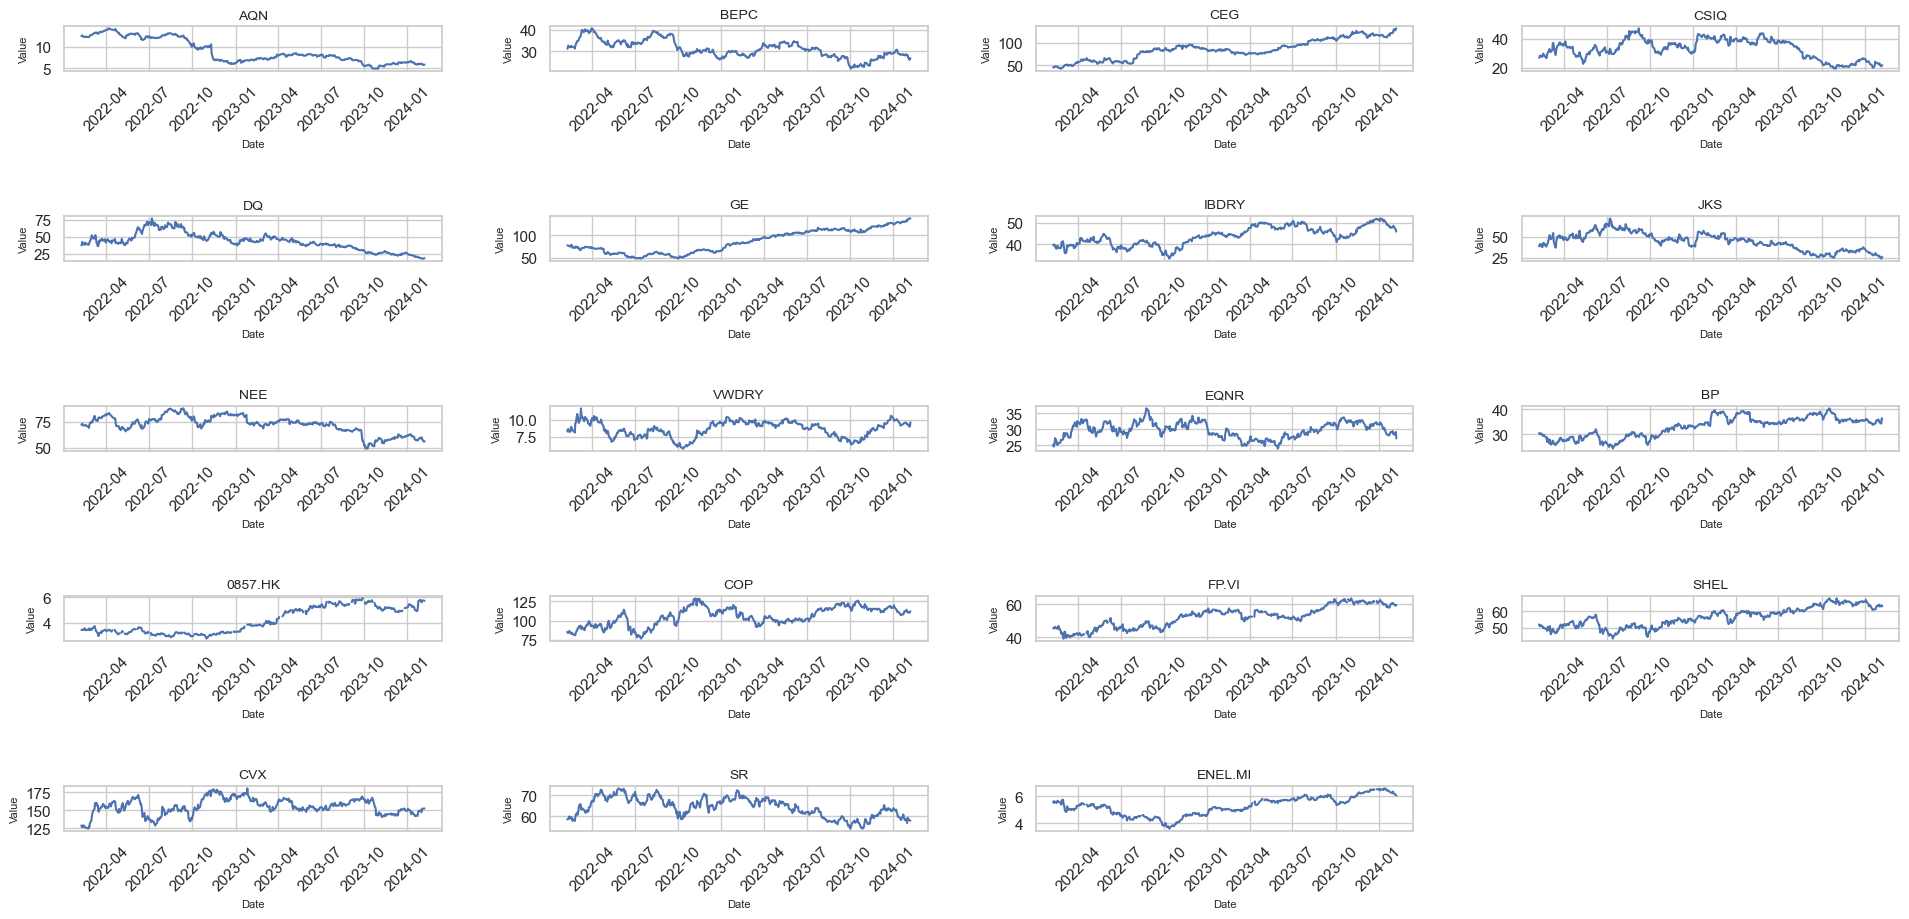

Box plot for distribution analysis


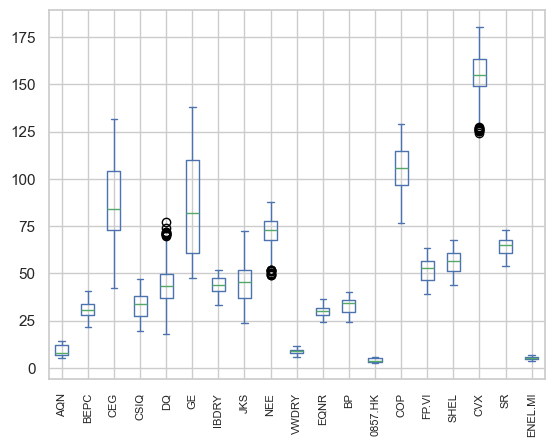

Heatmap for Correlation Between Assets


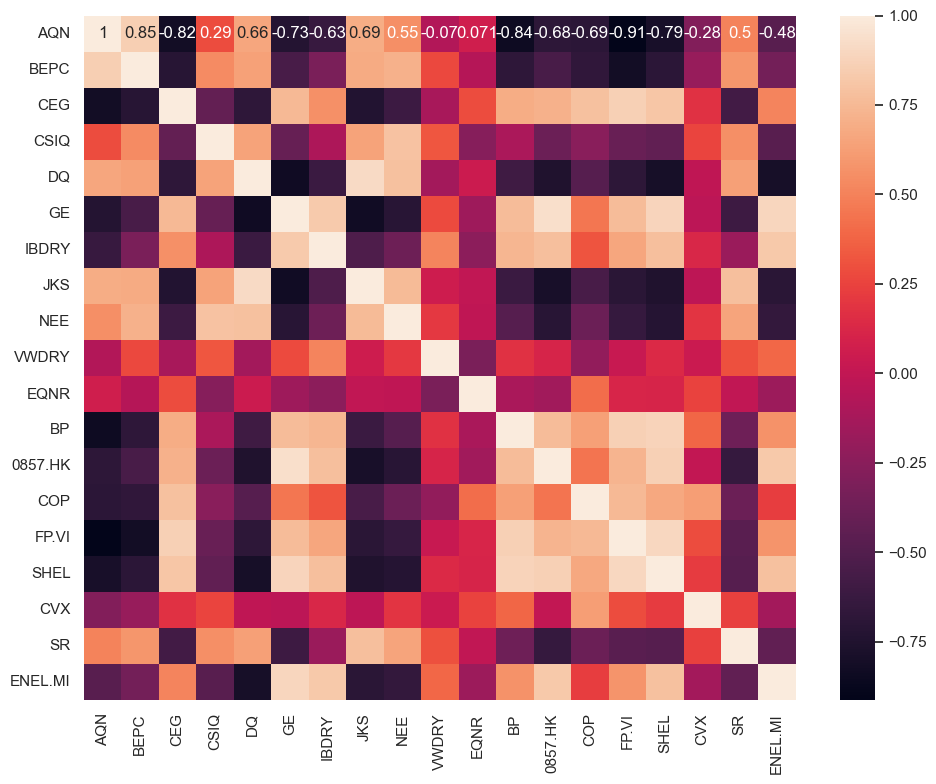

In [32]:
# Primary analysis
analyze_dataset(adj_close_df, summary_stat= True, data_quality = True, exploratory_analysis= True)


## Portfolio analysis

In [33]:
invested_amount = float(input("Enter amount to invest: "))

Enter amount to invest:  1000000


#### Optimal weights of assets

Maxmimum Expected Return Method:
Expected Annual Return: 0.2995
Expected Volatility: 0.2052
Sharpe Ratio: 1.5569
Minimum Variance Method:
Expected Annual Return: 0.1064
Expected Volatility: 0.1440
Sharpe Ratio: 0.8783
Maximum Sharpe Ratio Method:
Expected Annual Return: 0.2705
Expected Volatility: 0.1721
Sharpe Ratio: 1.6874


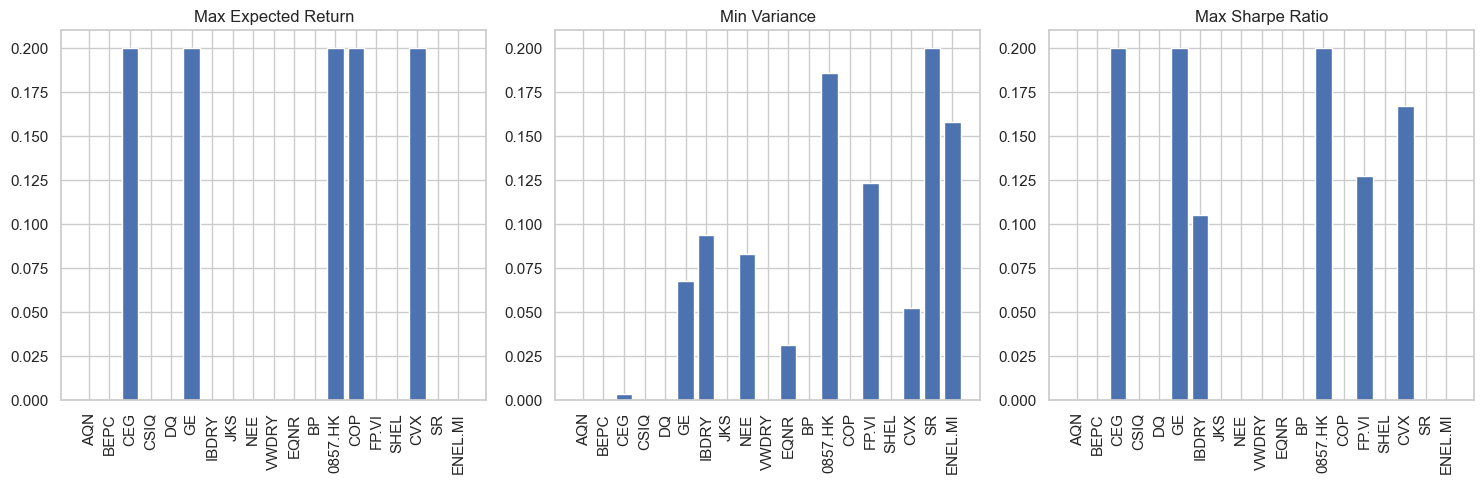

In [36]:
# Auxiliary variables for analysis
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
cov_matrix = log_returns.cov() * 252

# Optimal portfolio information for max_exp_return
optimal_result_max_exp_return = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="max_exp_return")
optimal_weights_max_exp_return = optimal_result_max_exp_return.x

# Optimal portfolio information for min_variance
optimal_result_min_variance = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="min_variance")
optimal_weights_min_variance = optimal_result_min_variance.x

# Optimal portfolio information for max_sharpe
optimal_result_max_sharpe = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="max_sharpe")
optimal_weights_max_sharpe = optimal_result_max_sharpe.x

# variance, expected return and Sharpe Ratio for each method

# Max. Expected return
max_exp_return = -neg_expected_return(optimal_weights_max_exp_return, log_returns = log_returns)
max_exp_volatility = standard_deviation(optimal_weights_max_exp_return, cov_matrix)
max_exp_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_max_exp_return, log_returns, cov_matrix, 0.02)

# Min. Variance
min_vol_return = -neg_expected_return(optimal_weights_min_variance, log_returns = log_returns)
min_vol_volatility = standard_deviation(optimal_weights_min_variance, cov_matrix)
min_vol_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_min_variance, log_returns, cov_matrix, 0.02)

# Max. Sharpe Ratio
max_sharpe_return = -neg_expected_return(optimal_weights_max_sharpe, log_returns = log_returns)
max_sharpe_vol = standard_deviation(optimal_weights_max_sharpe, cov_matrix)
max_sharpe_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_max_sharpe, log_returns, cov_matrix, 0.02)

# show the portfolio information for each:
print("Maxmimum Expected Return Method:")
print(f"Expected Annual Return: {max_exp_return:.4f}")
print(f"Expected Volatility: {max_exp_volatility:.4f}")
print(f"Sharpe Ratio: {max_exp_sharpe:.4f}")

print("Minimum Variance Method:")
print(f"Expected Annual Return: {min_vol_return:.4f}")
print(f"Expected Volatility: {min_vol_volatility:.4f}")
print(f"Sharpe Ratio: {min_vol_sharpe:.4f}")

print("Maximum Sharpe Ratio Method:")
print(f"Expected Annual Return: {max_sharpe_return:.4f}")
print(f"Expected Volatility: {max_sharpe_vol:.4f}")
print(f"Sharpe Ratio: {max_sharpe_sharpe:.4f}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for max_exp_return
axs[0].bar(tickers, optimal_weights_max_exp_return)
axs[0].set_title('Max Expected Return')
axs[0].tick_params(axis='x', rotation=90)

# Plot for min_variance
axs[1].bar(tickers, optimal_weights_min_variance)
axs[1].set_title('Min Variance')
axs[1].tick_params(axis='x', rotation=90)

# Plot for max_sharpe
axs[2].bar(tickers, optimal_weights_max_sharpe)
axs[2].set_title('Max Sharpe Ratio')
axs[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

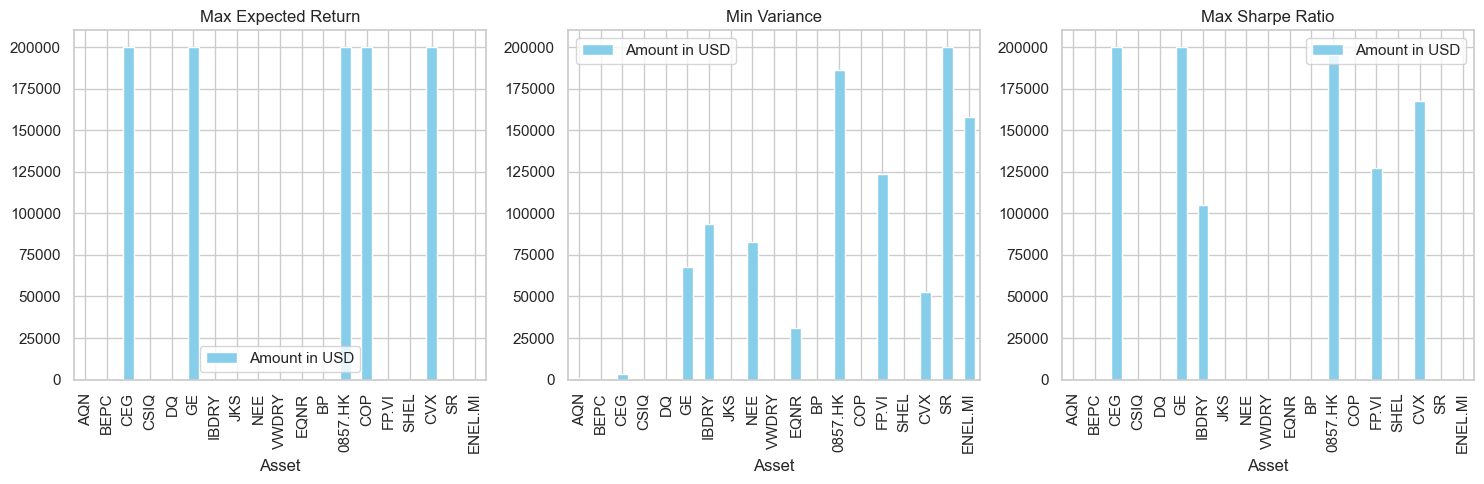

In [37]:
# Portfolio dataframe for max_exp
positions_max_exp = np.round(optimal_result_max_exp_return.x*float(invested_amount))
portfolio_max_exp = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_max_exp})

# Portfolio dataframe for min_variance
positions_min_variance = np.round(optimal_result_min_variance.x * float(invested_amount))
portfolio_min_variance = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_min_variance})

# Portfolio dataframe for max_sharpe
positions_max_sharpe = np.round(optimal_result_max_sharpe.x * float(invested_amount))
portfolio_max_sharpe = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_max_sharpe})

# Displaying portfolio breakdowns side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot for max_exp_return
portfolio_max_exp.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Max Expected Return')

# Plot for min_variance
portfolio_min_variance.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[1])
axs[1].set_title('Min Variance')

# Plot for max_sharpe
portfolio_max_sharpe.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[2])
axs[2].set_title('Max Sharpe Ratio')

# Adjust layout
plt.tight_layout()

plt.show()

In [56]:
sustainable_stocks = ['AQN', 'BEPC', 'CEG', 'CSIQ', 'DQ', 'GE', 'IBDRY', 'JKS', 'NEE', 'VWDRY']
unsustainable_stocks = ['EQNR', 'BP', '0857.HK', 'COP', 'FP.VI', 'SHEL', 'CVX', 'SR', 'ENEL.MI']

def calculate_sustainability_weight(optimal_weights, tickers, sustainable_stocks, unsustainable_stocks):
    sustainable_weight = sum(weight for ticker, weight in zip(tickers, optimal_weights) if ticker in sustainable_stocks)
    unsustainable_weight = sum(weight for ticker, weight in zip(tickers, optimal_weights) if ticker in unsustainable_stocks)
    return sustainable_weight, unsustainable_weight

# After obtaining optimal weights for any method
sustainable_weight, unsustainable_weight = calculate_sustainability_weight(optimal_weights_max_exp_return, tickers, sustainable_stocks, unsustainable_stocks)

print(f"Sustainable Weight: {sustainable_weight:.4f}")
print(f"Unsustainable Weight: {unsustainable_weight:.4f}")


Sustainable Weight: 0.4000
Unsustainable Weight: 0.6000


In [57]:
def process_and_plot_results(optimal_results, tickers, sustainable_stocks, unsustainable_stocks, method_names):
    fig, axs = plt.subplots(1, len(optimal_results), figsize=(15, 5))
    
    if len(optimal_results) == 1:  # Ensure axs is iterable for a single subplot
        axs = [axs]
    
    # Define pastel colors
    pastel_green = '#77dd77'  # Pastel green for sustainable
    pastel_red = '#ff6961'  # Pastel red for unsustainable
    
    for i, (optimal_weights, method_name) in enumerate(zip(optimal_results, method_names)):
        # Calculate sustainability weights
        sustainable_weight, unsustainable_weight = calculate_sustainability_weight(optimal_weights, tickers, sustainable_stocks, unsustainable_stocks)

        # Plotting
        axs[i].bar(['Sustainable', 'Unsustainable'], [sustainable_weight, unsustainable_weight], color=[pastel_green, pastel_red])
        axs[i].set_title(f'{method_name} Method')
        axs[i].set_ylabel('Weight')
        
        # Display the weights
        print(f"{method_name} Method Sustainability Weights:")
        print(f"Sustainable Weight: {sustainable_weight:.4f}")
        print(f"Unsustainable Weight: {unsustainable_weight:.4f}\n")

    plt.tight_layout()
    plt.show()

Maximum Expected Return Method Sustainability Weights:
Sustainable Weight: 0.4000
Unsustainable Weight: 0.6000

Minimum Variance Method Sustainability Weights:
Sustainable Weight: 0.2489
Unsustainable Weight: 0.7511

Maximum Sharpe Ratio Method Sustainability Weights:
Sustainable Weight: 0.5052
Unsustainable Weight: 0.4948



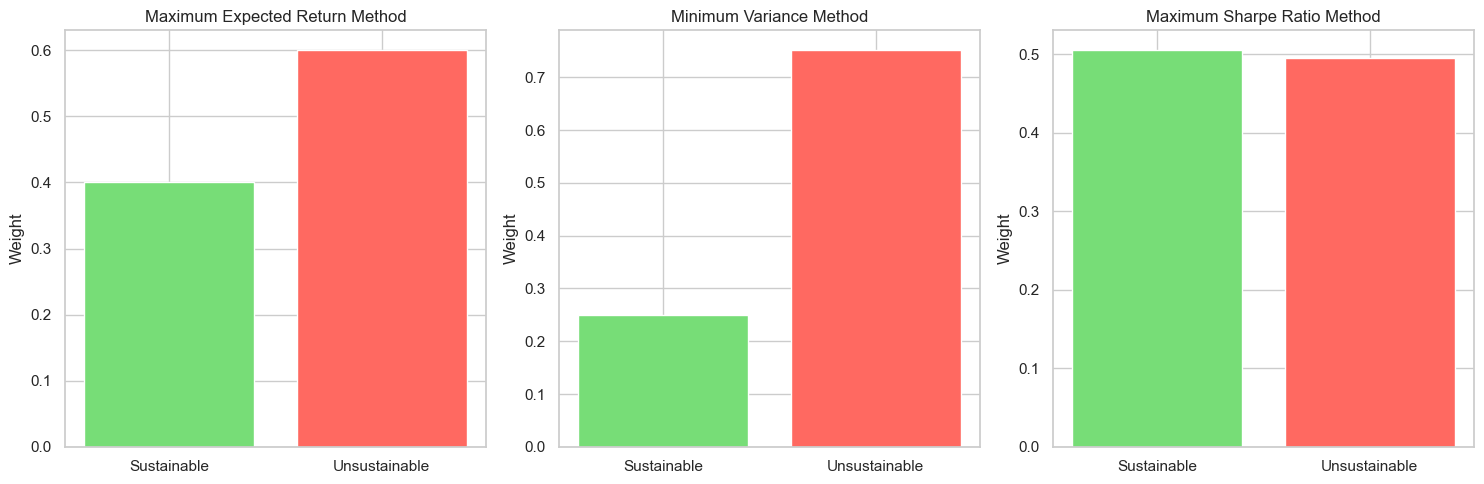

In [58]:
optimal_weights = [optimal_weights_max_exp_return, optimal_weights_min_variance, optimal_weights_max_sharpe]
method_names = ['Maximum Expected Return', 'Minimum Variance', 'Maximum Sharpe Ratio']

process_and_plot_results(optimal_weights, tickers, sustainable_stocks, unsustainable_stocks, method_names)


This is the end of the analysis, here we aim to  make monte carlo simulations of the  evolution of selected combinations of stocks.

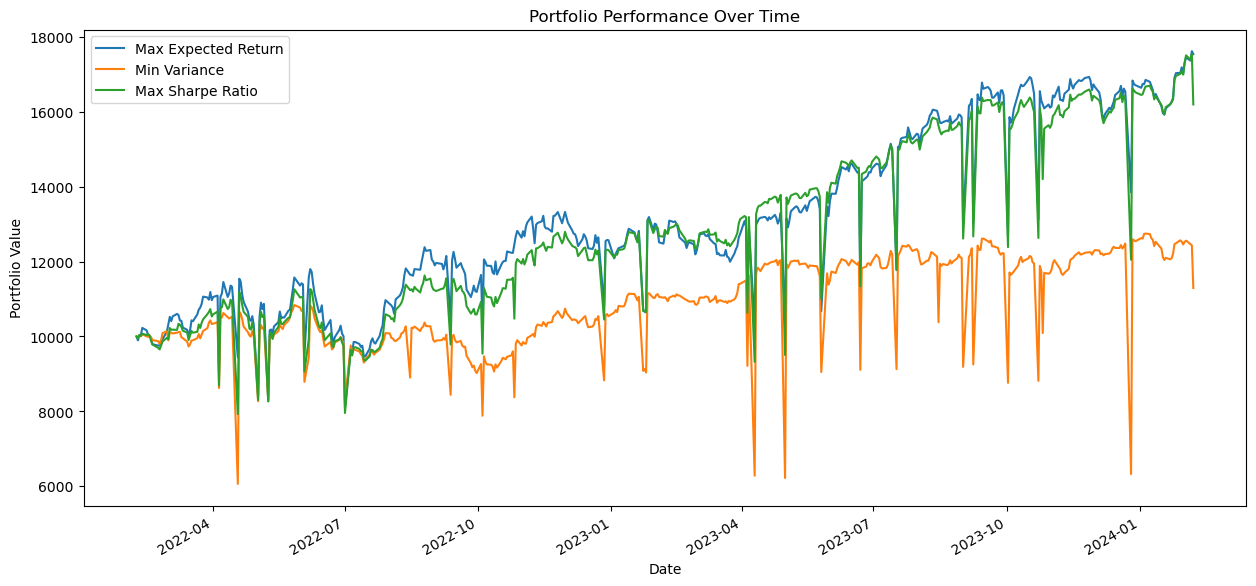

In [17]:
# Calculate the number of shares for each stock in the portfolio for each strategy
shares_max_exp_return = optimal_weights_max_exp_return * invested_amount / adj_close_df.iloc[0]
shares_min_variance = optimal_weights_min_variance * invested_amount / adj_close_df.iloc[0]
shares_max_sharpe = optimal_weights_max_sharpe * invested_amount / adj_close_df.iloc[0]

# Calculate the portfolio value over time for each strategy
portfolio_value_max_exp_return = (adj_close_df * shares_max_exp_return).sum(axis=1)
portfolio_value_min_variance = (adj_close_df * shares_min_variance).sum(axis=1)
portfolio_value_max_sharpe = (adj_close_df * shares_max_sharpe).sum(axis=1)

# Plot the portfolio values over time
plt.figure(figsize=(15, 7))
portfolio_value_max_exp_return.plot(label='Max Expected Return')
portfolio_value_min_variance.plot(label='Min Variance')
portfolio_value_max_sharpe.plot(label='Max Sharpe Ratio')
plt.title('Portfolio Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


The code provided assumes you are buying the stocks at the beginning of the period based on the adjusted close prices of the stocks on the first day of your historical data set. This approach provides a straightforward way to understand how the portfolio would have performed historically given the initial weights calculated by our optimization methods

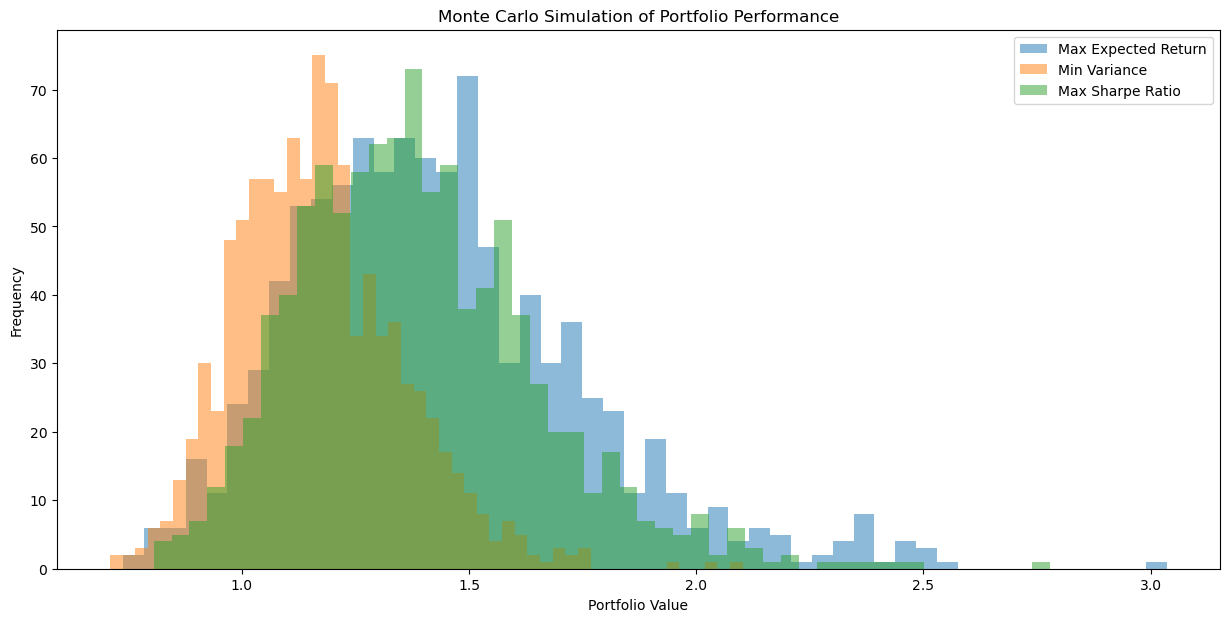

In [18]:
# Parameters
n_simulations = 1000  # Number of Monte Carlo simulations
n_days = 252  # Number of trading days in the future (e.g., 1 year)

# Historical log returns mean and covariance
mean_returns = log_returns.mean()
cov_matrix = log_returns.cov()

# Initialize arrays to store simulation results
simulated_portfolios_max_exp_return = np.zeros((n_simulations, n_days))
simulated_portfolios_min_variance = np.zeros((n_simulations, n_days))
simulated_portfolios_max_sharpe = np.zeros((n_simulations, n_days))

for i in range(n_simulations):
    # Generate random price paths for each stock
    daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, n_days)
    
    # Calculate the price paths
    price_paths = np.exp(daily_returns.cumsum(axis=0))
    
    # Calculate portfolio value for each strategy
    simulated_portfolios_max_exp_return[i, :] = (price_paths * optimal_weights_max_exp_return).sum(axis=1)
    simulated_portfolios_min_variance[i, :] = (price_paths * optimal_weights_min_variance).sum(axis=1)
    simulated_portfolios_max_sharpe[i, :] = (price_paths * optimal_weights_max_sharpe).sum(axis=1)

# Plotting the last day distribution for each strategy
plt.figure(figsize=(15, 7))

plt.hist(simulated_portfolios_max_exp_return[:, -1], bins=50, alpha=0.5, label='Max Expected Return')
plt.hist(simulated_portfolios_min_variance[:, -1], bins=50, alpha=0.5, label='Min Variance')
plt.hist(simulated_portfolios_max_sharpe[:, -1], bins=50, alpha=0.5, label='Max Sharpe Ratio')

plt.title('Monte Carlo Simulation of Portfolio Performance')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


This script simulates the future value of your portfolio under each optimization strategy using Monte Carlo simulations. It assumes that the daily returns of the stocks are normally distributed and uses the historical mean and covariance of the log returns as parameters for the simulation. The final histogram plots show the distribution of the simulated portfolio values at the end of the simulation period, providing insight into the range of potential outcomes for each strategy.

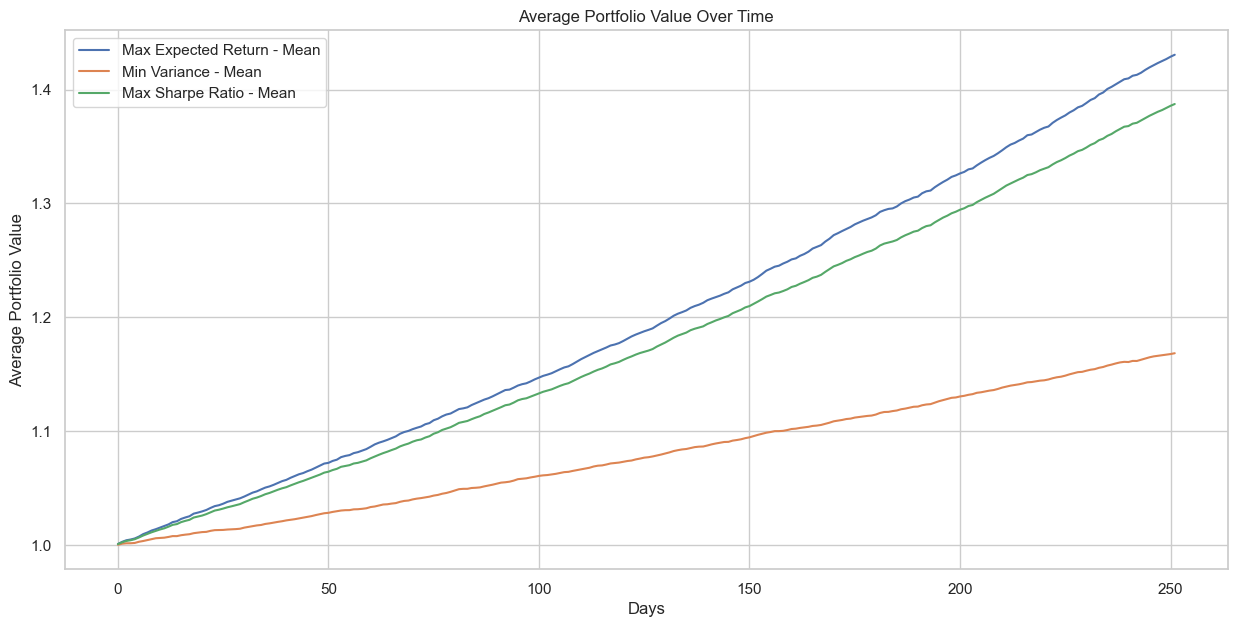

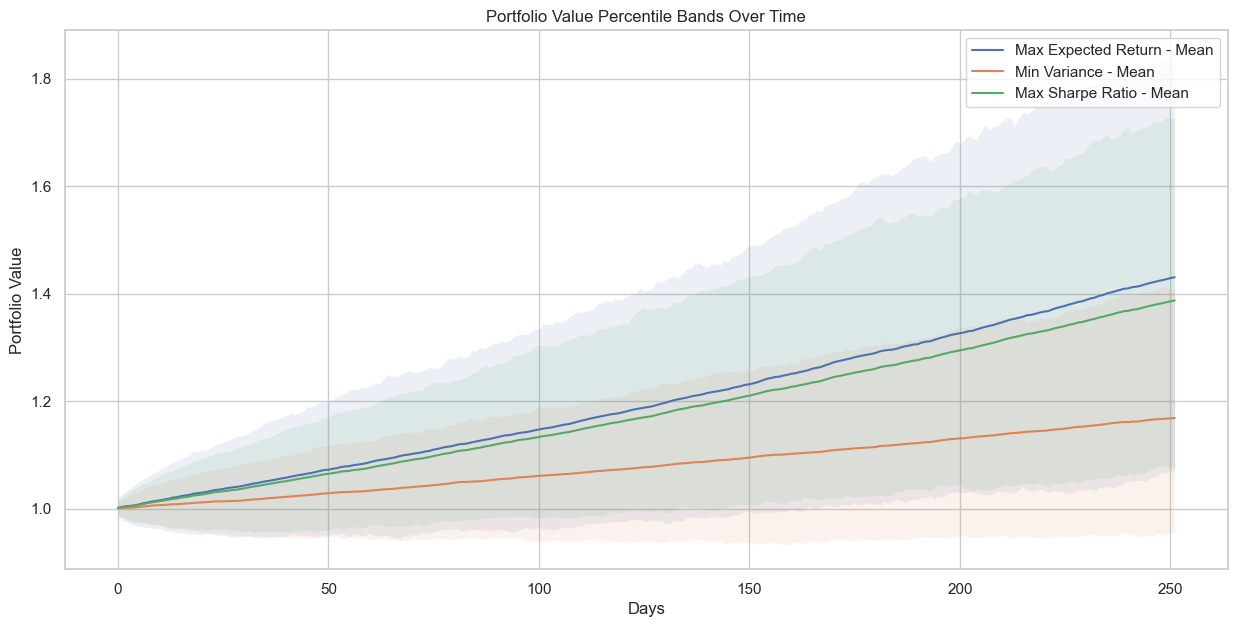

C:\Users\Terstudy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Terstudy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Terstudy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Terstudy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

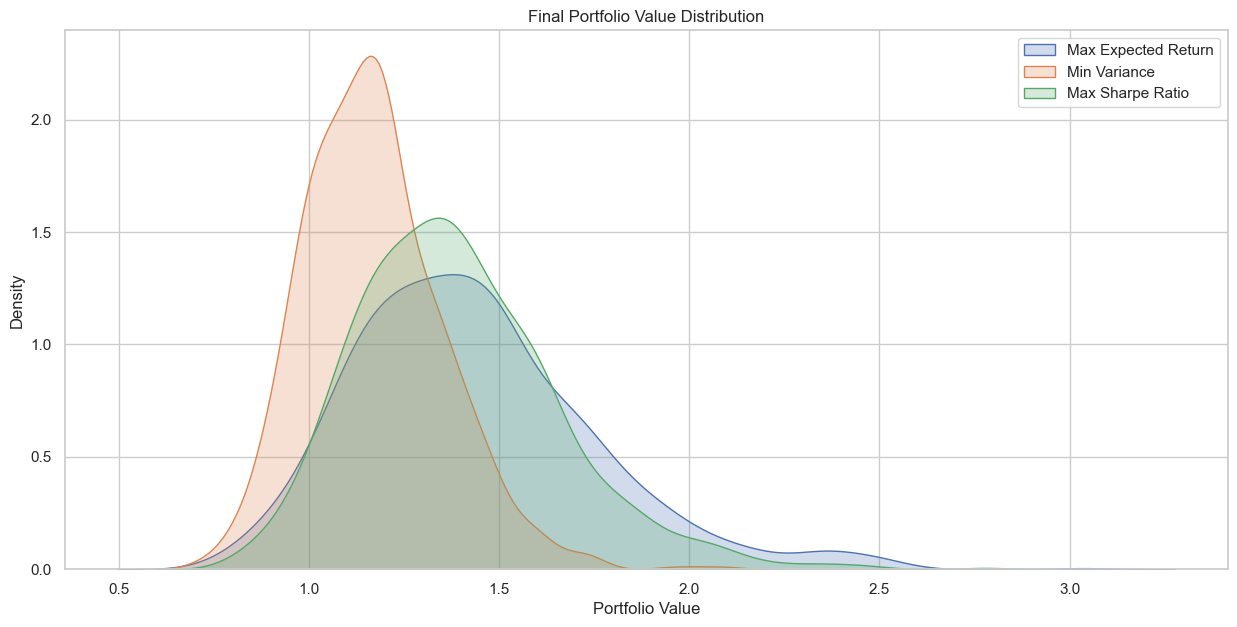

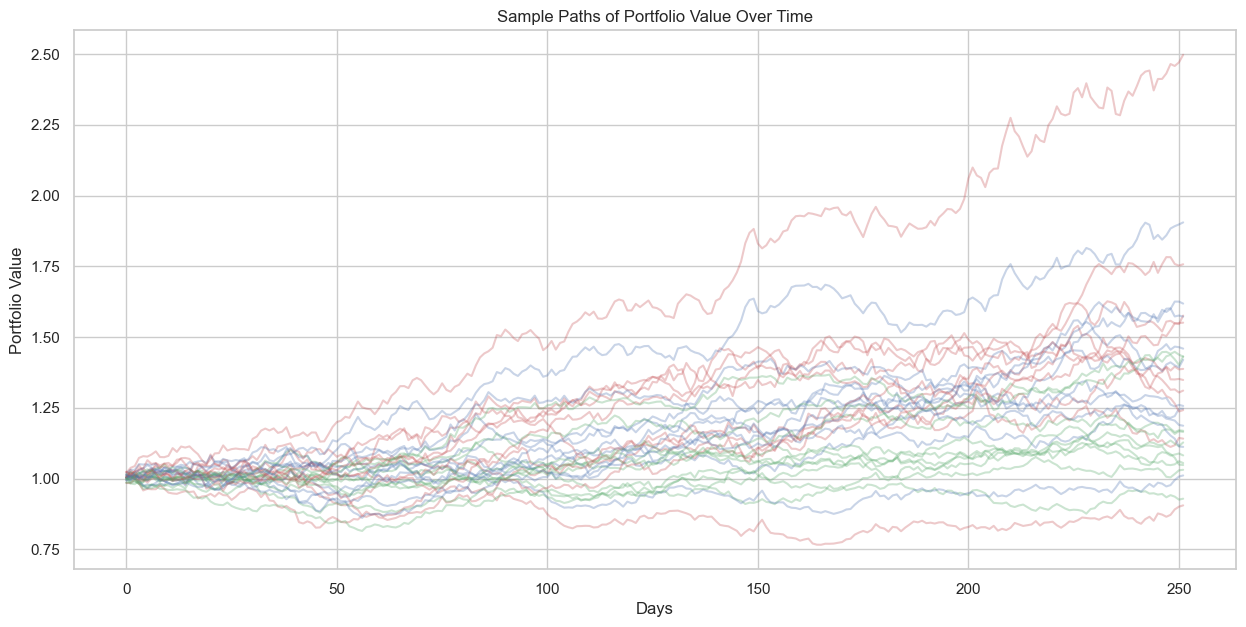

In [21]:
sns.set(style='whitegrid')

# 1. Average Portfolio Value Over Time
plt.figure(figsize=(15, 7))
plt.plot(simulated_portfolios_max_exp_return.mean(axis=0), label='Max Expected Return - Mean')
plt.plot(simulated_portfolios_min_variance.mean(axis=0), label='Min Variance - Mean')
plt.plot(simulated_portfolios_max_sharpe.mean(axis=0), label='Max Sharpe Ratio - Mean')
plt.title('Average Portfolio Value Over Time')
plt.xlabel('Days')
plt.ylabel('Average Portfolio Value')
plt.legend()
plt.show()

# 2. Percentile Bands of Portfolio Value
plt.figure(figsize=(15, 7))
for strategy, label in zip([simulated_portfolios_max_exp_return, simulated_portfolios_min_variance, simulated_portfolios_max_sharpe], 
                           ['Max Expected Return', 'Min Variance', 'Max Sharpe Ratio']):
    upper_band = np.percentile(strategy, 90, axis=0)
    lower_band = np.percentile(strategy, 10, axis=0)
    plt.fill_between(range(n_days), lower_band, upper_band, alpha=0.1)
    plt.plot(strategy.mean(axis=0), label=label + ' - Mean')
plt.title('Portfolio Value Percentile Bands Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 3. Final Portfolio Value Distribution with KDE
plt.figure(figsize=(15, 7))
sns.kdeplot(simulated_portfolios_max_exp_return[:, -1], label='Max Expected Return', fill=True)
sns.kdeplot(simulated_portfolios_min_variance[:, -1], label='Min Variance', fill=True)
sns.kdeplot(simulated_portfolios_max_sharpe[:, -1], label='Max Sharpe Ratio', fill=True)
plt.title('Final Portfolio Value Distribution')
plt.xlabel('Portfolio Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# 4. Overlay of Sample Paths
plt.figure(figsize=(15, 7))
for i in range(10):  # Plot 10 sample paths from each strategy
    plt.plot(simulated_portfolios_max_exp_return[i, :], 'r', alpha=0.3)
    plt.plot(simulated_portfolios_min_variance[i, :], 'g', alpha=0.3)
    plt.plot(simulated_portfolios_max_sharpe[i, :], 'b', alpha=0.3)
plt.title('Sample Paths of Portfolio Value Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.show()

end of code